In [1]:
import json
import time

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

pd.set_option('display.max_rows', 100)

In [2]:
import pickle
import glob

base_path = os.path.dirname(os.getcwd())
master_data_path = os.path.abspath(os.path.join(base_path,'master-data'))
data_path = os.path.abspath(os.path.join(base_path,'data'))
images_path = os.path.abspath(os.path.join(base_path,'dm-final-report', 'images'))   

In [ ]:
title_basics_crew_principals_ratings_merged_df = pd.read_pickle(os.path.join(data_path,"title.basics.crew.principals.ratings.cleaned.sav"))
title_principals_df = pd.read_pickle(os.path.join(data_path,"title.principals.cleaned.sav"))
name_basics_original_df = pd.read_pickle(os.path.join(master_data_path,"name.basics.sav"))

# SOM Clustering

In [3]:
# read df_read_for_kmeans

df_read_for_kmeans = pd.read_pickle(os.path.join(data_path,"df_read_for_kmeans.sav"))
df_read_for_kmeans

,tconst,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,actor_score,actress_score,director_score,writer_score
0,tt0000009,False,1894,45,Romance,5.3,209,0.281154,0.238934,0.238965,0.238943
1,tt0000574,False,1906,70,"Action,Adventure,Biography",6.0,876,0.277972,0.277972,0.278103,0.278007
21,tt0000591,False,1907,90,Drama,5.5,23,0.266678,0.250004,0.250007,0.233341
23,tt0000941,False,1909,45,Drama,4.6,28,0.250931,0.200005,0.212971,0.276668
25,tt0001184,False,1910,58,"Adventure,Drama",3.8,22,0.216671,0.155559,0.212971,0.216674
...,...,...,...,...,...,...,...,...,...,...,...
634466,tt9916190,False,2020,95,"Action,Adventure,Thriller",3.6,255,0.283365,0.144500,0.144538,0.172270
634467,tt9916270,False,2020,84,Thriller,5.8,1475,0.292735,0.282253,0.233734,0.267053
634469,tt9916362,False,2020,92,"Drama,History",6.4,5754,0.291351,0.306038,0.276346,0.301511
634470,tt9916538,False,2019,123,Drama,8.6,7,0.343074,0.337452,0.307609,0.347330


In [36]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from minisom import MiniSom
from sklearn.metrics import silhouette_score


data = df_read_for_kmeans.sample(100000).copy().reset_index(drop=True)



# Handle categorical data
mlb = MultiLabelBinarizer()
data['genres'] = data['genres'].apply(lambda x: x.split(','))
genres_encoded = mlb.fit_transform(data['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Prepare the dataset for training
features = pd.concat([data.drop(['tconst', 'genres'], axis=1), genres_df], axis=1)
features = features.astype(float)  # Ensure all data is float for MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Initialize and train SOM
som = MiniSom(x=10, y=10, input_len=features_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(features_scaled)
som.train_random(features_scaled, num_iteration=100)

# Map each movie to its cluster
winner_coordinates = np.array([som.winner(x) for x in features_scaled])  # no transpose needed
mapped = pd.DataFrame(winner_coordinates, columns=['x', 'y'])
data['cluster'] = mapped.apply(lambda r: str(r['x']) + '-' + str(r['y']), axis=1)

# Evaluate clustering
labels = mapped.apply(lambda r: r['x']*10 + r['y'], axis=1)  # Convert 2D coordinates to unique cluster labels
score = silhouette_score(features_scaled, labels)
print('Silhouette Score: %.2f' % score)

# Display data with assigned cluster
print(f"Number of clusters: {data['cluster'].nunique()}")

data[['tconst', 'cluster']].to_pickle(os.path.join(data_path,"som_clustered.sav"))

Silhouette Score: 0.24
Number of clusters: 94


In [37]:
som_clustered = pd.read_pickle(os.path.join(data_path,"som_clustered.sav"))
som_clustered

,tconst,cluster
0,tt0140683,1-9
1,tt0020258,2-4
2,tt23806182,2-4
3,tt0452580,7-7
4,tt0228720,9-9
...,...,...
99995,tt0026647,9-6
99996,tt0416765,2-4
99997,tt0262446,7-2
99998,tt0163154,5-6


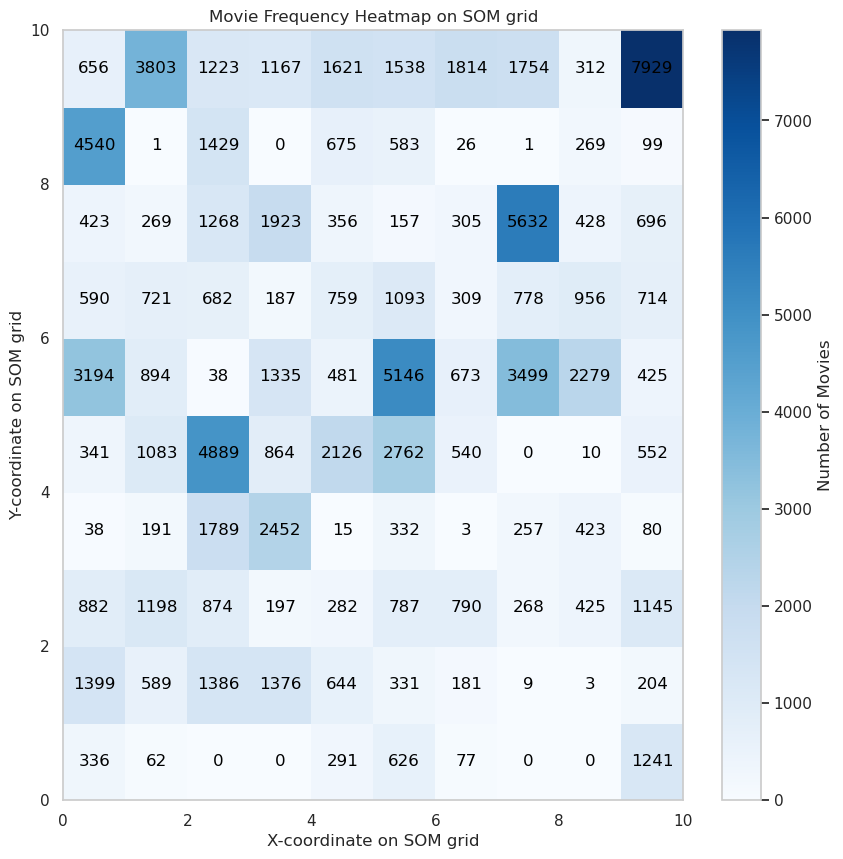

In [38]:
# Define SOM grid dimensions (assumed to be 10x10 in this example)
som_grid_dimensions = (10, 10)  

# Create a matrix to hold the count of movies in each grid cell
grid_frequency = np.zeros(som_grid_dimensions)

# Increment grid cells' frequency based on the movie's winning coordinates
for i, (x, y) in enumerate(winner_coordinates):
    grid_frequency[x, y] += 1

# Now create a heatmap
plt.figure(figsize=(10, 10))
plt.pcolor(grid_frequency.T, cmap='Blues')  # Transpose to match orientation
plt.colorbar(label='Number of Movies')

# Add labels with the count of movies to each cell (optional, may clutter the heatmap if too many movies)
for i in range(som_grid_dimensions[0]):
    for j in range(som_grid_dimensions[1]):
        plt.text(i + 0.5, j + 0.5, int(grid_frequency[i, j]),
                 ha='center', va='center', color='black')

plt.xlabel('X-coordinate on SOM grid')
plt.ylabel('Y-coordinate on SOM grid')
plt.title('Movie Frequency Heatmap on SOM grid')

plt.show()
